In [1]:
!kaggle datasets download snehilsanyal/construction-site-safety-image-dataset-roboflow

Dataset URL: https://www.kaggle.com/datasets/snehilsanyal/construction-site-safety-image-dataset-roboflow
License(s): Attribution 4.0 International (CC BY 4.0)
 97% 200M/206M [00:01<00:00, 149MB/s]
100% 206M/206M [00:01<00:00, 154MB/s]


<h1 style="padding: 25px 25px; background-color: #F5B041; font-family: Sans-Serif; color:black; text-align: center">
Project: Safety Helmet Detection</h1>

In [4]:
pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 922.1/922.1 kB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 66.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [5]:
import zipfile as zipfile
with zipfile.ZipFile('construction-site-safety-image-dataset-roboflow.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [6]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from IPython.core.magic import register_line_cell_magic
import yaml
from PIL import Image
import os
import seaborn as sns
from ultralytics import YOLO
from matplotlib.patches import Rectangle
import glob
import cv2


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [7]:
warnings.filterwarnings("ignore")

np.random.seed(12345)

%matplotlib inline

!wandb disabled

W&B disabled.


In [8]:
INPUT_DIR = '/content/css-data'
WORK_DIR = '/content/results_yolov8n_100e/kaggle/working'

In [9]:
num_classes = 10
classes = ['Helmet', 'Mask', 'NO-Helmet', 'NO-Mask', 'NO-Safety Vest', 'Person', 'Safety Cone', 'Safety Vest', 'machinery', 'vehicle']

In [10]:
dict_file = {'train': os.path.join(INPUT_DIR, 'train'),
             'val': os.path.join(INPUT_DIR, 'valid'),
             'test': os.path.join(INPUT_DIR, 'test'),
             'nc': num_classes,
             'names': classes
            }

with open(os.path.join(WORK_DIR, 'data.yaml'), 'w+') as file:
    yaml.dump(dict_file, file)

<h4 style="border-bottom: 3px solid #FAD7A0; padding: 12px 12px; font-family: Sans-Serif; color:black">
<b>Check class balance</b></h4>

In [11]:
class_idx = {str(i):classes[i] for i in range(num_classes)}

class_stat = {}
data_len = {}

for mode in ['train', 'valid', 'test']:

    class_count = {classes[i]:0 for i in range(num_classes)}

    path = os.path.join(INPUT_DIR, mode, 'labels')

    for file in os.listdir(path):

        with open(os.path.join(path, file)) as f:
            lines = f.readlines()

            for cls in set([line[0] for line in lines]):
                class_count[class_idx[cls]] += 1

    data_len[mode] = len(os.listdir(path))
    class_stat[mode] = class_count

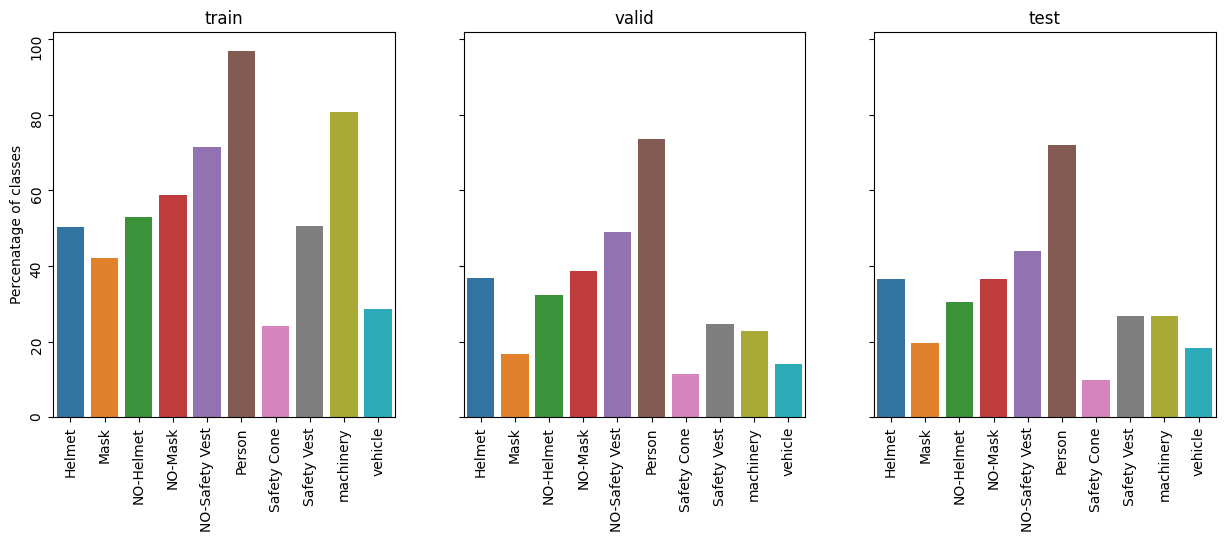

In [12]:
fig, ax = plt.subplots(1,3, figsize=(15, 5), sharey=True)

for i, mode in enumerate(['train', 'valid', 'test']):
    sns.barplot(pd.DataFrame({mode:class_stat[mode]}).T/data_len[mode]*100, ax=ax[i])
    ax[i].set_title(mode)
    ax[i].tick_params(rotation=90)
    ax[i].set_ylabel('Percenatage of classes')
plt.show()

<h4 style="border-bottom: 3px solid #FAD7A0; padding: 12px 12px; font-family: Sans-Serif; color:black">
<b>Check image sizes</b></h4>

In [13]:
for mode in ['train', 'valid', 'test']:
    print(f'\nImage sizes in {mode} set:\n')
    img_size = 0
    for file in glob.glob(os.path.join(INPUT_DIR, mode, 'images', '*')):
        image = Image.open(file)
        if image.size != img_size:
            print(f'\t{image.size}')
            img_size = image.size


Image sizes in train set:

	(640, 640)

Image sizes in valid set:

	(640, 640)

Image sizes in test set:

	(640, 640)


- All images have size `640x640`

<h4 style="border-bottom: 3px solid #FAD7A0; padding: 12px 12px; font-family: Sans-Serif; color:black">
<b>Check dataset sizes</b></h4>

In [14]:
for mode in ['train', 'valid', 'test']:

    files =  glob.glob(os.path.join(INPUT_DIR, mode, 'images', '*'))

    print(f'{mode} set size: {len(files)}\n')

train set size: 2605

valid set size: 114

test set size: 82



<a id="train"></a>

<h2 style="padding: 12px 12px; background-color: #F5B041; font-family: Sans-Serif; color:black">
Train</h2>

<h4 style="border-bottom: 3px solid #FAD7A0; padding: 12px 12px; font-family: Sans-Serif; color:black">
<b>Arguments for training</b></h4>

- **task**: preform `detect`, `segment` or `classify`
- **imgsz**: define input image size
- **batch**: determine batch size
- **epochs**: define the number of training epochs. (Note: often, 3000+ are common here!)
- **data**: set the path to our yaml file
- **mode**: mode - `train`, `val` or `predict`
- **model**: model to use (could be pre-trained)
- **name**: result names

<h4 style="border-bottom: 3px solid #FAD7A0; padding: 12px 12px; font-family: Sans-Serif; color:black">
<b>Load model<b></h4>

- Load `pre-trained` YOLO-nano model

In [15]:
model = YOLO('yolov8n.pt')

100%|██████████| 6.25M/6.25M [00:00<00:00, 111MB/s]


<h4 style="border-bottom: 3px solid #FAD7A0; padding: 12px 12px; font-family: Sans-Serif; color:black">
<b>Train</b></h4>

In [16]:
model.train(data=os.path.join(WORK_DIR,'data.yaml'),
            task='detect',
            imgsz=640,
            epochs=30,
            batch=32,
            mode='train',
            name='yolov8n_v1_train')

Ultralytics 8.3.81 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/results_yolov8n_100e/kaggle/working/data.yaml, epochs=30, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8n_v1_train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_

100%|██████████| 755k/755k [00:00<00:00, 27.5MB/s]


Overriding model.yaml nc=80 with nc=10

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytic

100%|██████████| 5.35M/5.35M [00:00<00:00, 117MB/s]


AMP: checks passed ✅


train: Scanning /content/css-data/train/labels... 2605 images, 6 backgrounds, 0 corrupt: 100%|██████████| 2605/2605 [00:01<00:00, 2170.72it/s]

train: WARNING ⚠️ /content/css-data/train/images/004720_jpg.rf.afc486560a4004c7cfd67910af31a29c.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/css-data/train/images/construction-813-_jpg.rf.b085952261fd98f2e76b8065de149b5f.jpg: 1 duplicate labels removed


train: New cache created: /content/css-data/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/css-data/valid/labels... 114 images, 10 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<00:00, 1231.48it/s]

val: New cache created: /content/css-data/valid/labels.cache


Plotting labels to runs/detect/yolov8n_v1_train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/yolov8n_v1_train
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30       5.5G      1.463      3.106      1.547        422        640: 100%|██████████| 82/82 [00:46<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.32s/it]

                   all        114        697      0.536      0.219      0.276      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      6.09G      1.376      2.072      1.498        261        640: 100%|██████████| 82/82 [00:44<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.20s/it]

                   all        114        697      0.573      0.312      0.365      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      5.76G      1.315      1.844      1.465        314        640: 100%|██████████| 82/82 [00:42<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.17it/s]

                   all        114        697      0.562      0.397      0.419       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      5.93G      1.298      1.741      1.441        330        640: 100%|██████████| 82/82 [00:42<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]

                   all        114        697      0.535      0.411      0.397      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      5.38G      1.261      1.663      1.405        275        640: 100%|██████████| 82/82 [00:42<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]

                   all        114        697      0.617      0.445      0.485      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      6.01G      1.235      1.563       1.39        256        640: 100%|██████████| 82/82 [00:43<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all        114        697      0.555      0.489      0.498      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30       6.3G      1.214      1.518      1.373        263        640: 100%|██████████| 82/82 [00:42<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.34it/s]

                   all        114        697       0.62      0.535       0.55      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      5.15G      1.202      1.472      1.361        344        640: 100%|██████████| 82/82 [00:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]

                   all        114        697      0.739      0.531      0.582      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      5.44G      1.179       1.43      1.345        327        640: 100%|██████████| 82/82 [00:42<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.25it/s]

                   all        114        697      0.652      0.555      0.581      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      5.49G      1.157      1.379       1.33        316        640: 100%|██████████| 82/82 [00:46<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.25it/s]

                   all        114        697      0.718      0.552      0.602       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      4.67G      1.148      1.361      1.318        286        640: 100%|██████████| 82/82 [00:44<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]

                   all        114        697      0.717       0.58      0.613       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      6.88G      1.135      1.305      1.308        287        640: 100%|██████████| 82/82 [00:50<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.37it/s]

                   all        114        697       0.79      0.527      0.621      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      6.05G      1.121      1.274      1.298        276        640: 100%|██████████| 82/82 [00:42<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.19it/s]

                   all        114        697      0.697      0.581      0.609      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      5.46G       1.11      1.253      1.289        329        640: 100%|██████████| 82/82 [00:46<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]

                   all        114        697      0.773      0.592      0.654      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      5.97G      1.105      1.232      1.289        158        640: 100%|██████████| 82/82 [00:46<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.33it/s]

                   all        114        697      0.788      0.583      0.656      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      5.38G      1.102      1.227       1.28        246        640: 100%|██████████| 82/82 [00:42<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.29it/s]

                   all        114        697      0.769      0.615       0.66      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      6.29G       1.08      1.186      1.267        379        640: 100%|██████████| 82/82 [00:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.36it/s]

                   all        114        697      0.813      0.589      0.673      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      6.19G      1.074      1.189      1.269        265        640: 100%|██████████| 82/82 [00:43<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.25it/s]

                   all        114        697      0.816      0.583      0.676      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      6.26G      1.071      1.147      1.259        343        640: 100%|██████████| 82/82 [00:43<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.35it/s]

                   all        114        697      0.829      0.602      0.684      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      5.81G      1.055      1.133      1.248        426        640: 100%|██████████| 82/82 [00:42<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.11it/s]

                   all        114        697      0.828      0.605      0.691      0.369


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      4.74G      1.095      1.081      1.275        245        640: 100%|██████████| 82/82 [00:42<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        114        697       0.81      0.627      0.686      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      5.04G      1.073      1.031      1.263        206        640: 100%|██████████| 82/82 [00:40<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all        114        697      0.798      0.634      0.702      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      4.76G      1.061      1.005      1.249        183        640: 100%|██████████| 82/82 [00:40<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]

                   all        114        697      0.819      0.635        0.7      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      5.39G      1.048     0.9887      1.248        155        640: 100%|██████████| 82/82 [00:39<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]

                   all        114        697      0.827      0.646      0.708      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      5.06G       1.03     0.9657      1.233        132        640: 100%|██████████| 82/82 [00:39<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.33it/s]

                   all        114        697      0.855      0.632      0.715      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      5.44G      1.025      0.942      1.227        141        640: 100%|██████████| 82/82 [00:39<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]

                   all        114        697      0.841      0.656      0.724      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      5.11G      1.014     0.9301      1.222        217        640: 100%|██████████| 82/82 [00:39<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.38it/s]

                   all        114        697       0.88      0.649      0.727      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      4.75G      1.003     0.9163      1.213        175        640: 100%|██████████| 82/82 [00:39<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.39it/s]

                   all        114        697      0.836      0.669      0.732      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      4.67G     0.9954     0.9066      1.212        159        640: 100%|██████████| 82/82 [00:39<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.19it/s]

                   all        114        697      0.837      0.669      0.733      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      4.97G     0.9825     0.8882      1.197        205        640: 100%|██████████| 82/82 [00:39<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.39it/s]

                   all        114        697      0.834      0.677      0.731      0.411



30 epochs completed in 0.380 hours.
Optimizer stripped from runs/detect/yolov8n_v1_train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/yolov8n_v1_train/weights/best.pt, 6.2MB

Validating runs/detect/yolov8n_v1_train/weights/best.pt...
Ultralytics 8.3.81 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,007,598 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]


                   all        114        697      0.837      0.669      0.733      0.421
                Helmet         42         79      0.889      0.747      0.802      0.515
                  Mask         19         21      0.944       0.81       0.83      0.561
             NO-Helmet         37         69      0.871      0.536      0.671      0.321
               NO-Mask         44         74      0.766      0.432      0.557       0.25
        NO-Safety Vest         56        106      0.882      0.604       0.69      0.364
                Person         84        166       0.82      0.681      0.755      0.461
           Safety Cone         13         44      0.815      0.841      0.863      0.444
           Safety Vest         28         41      0.879      0.711      0.801      0.454
             machinery         26         55      0.753      0.832      0.847      0.532
               vehicle         16         42      0.751        0.5      0.517      0.306
Speed: 0.2ms preproce

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7977719d7c10>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.0

<a id="test"></a>

<h2 style="padding: 12px 12px; background-color: #F5B041; font-family: Sans-Serif; color:black">
Test</h2>

<h4 style="border-bottom: 3px solid #FAD7A0; padding: 12px 12px; font-family: Sans-Serif; color:black">
<b>Select best model</b></h4>

In [17]:
model = YOLO('runs/detect/yolov8n_v1_train/weights/best.pt')

<h4 style="border-bottom: 3px solid #FAD7A0; padding: 12px 12px; font-family: Sans-Serif; color:black">
<b>Make predicitons on test set</b></h4>

In [18]:
results = model.predict(source=os.path.join(INPUT_DIR, 'test', 'images'), save=True)


image 1/82 /content/css-data/test/images/-4405-_png_jpg.rf.82b5c10b2acd1cfaa24259ada8e599fe.jpg: 640x640 1 Person, 2 machinerys, 8.1ms
image 2/82 /content/css-data/test/images/000005_jpg.rf.96e9379ccae638140c4a90fc4b700a2b.jpg: 640x640 2 Helmets, 2 NO-Masks, 4 Persons, 3 machinerys, 7.4ms
image 3/82 /content/css-data/test/images/002551_jpg.rf.ce4b9f934161faa72c80dc6898d37b2d.jpg: 640x640 2 Helmets, 1 NO-Mask, 2 NO-Safety Vests, 4 Persons, 7.4ms
image 4/82 /content/css-data/test/images/003357_jpg.rf.9867f91e88089bb68dc95947d5116d14.jpg: 640x640 1 Helmet, 1 NO-Mask, 1 NO-Safety Vest, 1 Person, 1 Safety Cone, 7.4ms
image 5/82 /content/css-data/test/images/004063_jpg.rf.1b7cdc4035bcb24ef69b8798b444053e.jpg: 640x640 5 Helmets, 4 NO-Safety Vests, 6 Persons, 2 Safety Vests, 7.4ms
image 6/82 /content/css-data/test/images/004763_jpg.rf.46484e6ca73caeaa9de45822cf1085a9.jpg: 640x640 3 Helmets, 2 NO-Masks, 4 NO-Safety Vests, 3 Persons, 7.4ms
image 7/82 /content/css-data/test/images/006463_jpg.rf.

<h4 style="border-bottom: 3px solid #FAD7A0; padding: 12px 12px; font-family: Sans-Serif; color:black">
<b>Show prediction results</b></h4>

In [19]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ultralytics import YOLO
from sklearn.metrics import confusion_matrix, classification_report

# Load trained YOLO model
model = YOLO('/content/best.pt')

# Define input directory (test images)
INPUT_DIR = "/content/css-data"

# Run inference
results = model.predict(source=os.path.join(INPUT_DIR, 'test', 'images'), save=True)

# Initialize lists to store true and predicted labels
true_labels = []
pred_labels = []

# Load true labels from test/labels directory
label_dir = os.path.join(INPUT_DIR, 'test', 'labels')
label_files = sorted(os.listdir(label_dir))

for label_file in label_files:
    with open(os.path.join(label_dir, label_file), 'r') as f:
        lines = f.readlines()
        for line in lines:
            class_id = int(line.split()[0])  # Extract class label
            true_labels.append(class_id)

# Extract predicted labels from results
for result in results:
    if result.boxes is not None and len(result.boxes) > 0:
        pred_labels.extend([int(box.cls.item()) for box in result.boxes])  # Extract predicted classes
    else:
        pred_labels.append(-1)  # Assign a default label for missing detections

# Ensure the lists have the same length
min_length = min(len(true_labels), len(pred_labels))
true_labels = true_labels[:min_length]
pred_labels = pred_labels[:min_length]



FileNotFoundError: [Errno 2] No such file or directory: '/content/best.pt'

In [ ]:

# Compute confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=set(true_labels), yticklabels=set(true_labels))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(true_labels, pred_labels))

Ultralytics 8.3.81 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,007,598 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/css-data/valid/labels.cache... 114 images, 10 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.28it/s]


                   all        114        697      0.841      0.668      0.733      0.421
                Helmet         42         79      0.893      0.747      0.798      0.509
                  Mask         19         21      0.944       0.81       0.83      0.557
             NO-Helmet         37         69       0.88      0.536      0.671      0.322
               NO-Mask         44         74      0.786      0.432      0.556      0.251
        NO-Safety Vest         56        106      0.885      0.604       0.69      0.364
                Person         84        166      0.823      0.681      0.758      0.462
           Safety Cone         13         44      0.816      0.841      0.863      0.447
           Safety Vest         28         41      0.879      0.708        0.8      0.451
             machinery         26         55      0.752      0.827      0.848      0.535
               vehicle         16         42      0.754        0.5      0.514      0.309
Speed: 8.6ms preproce

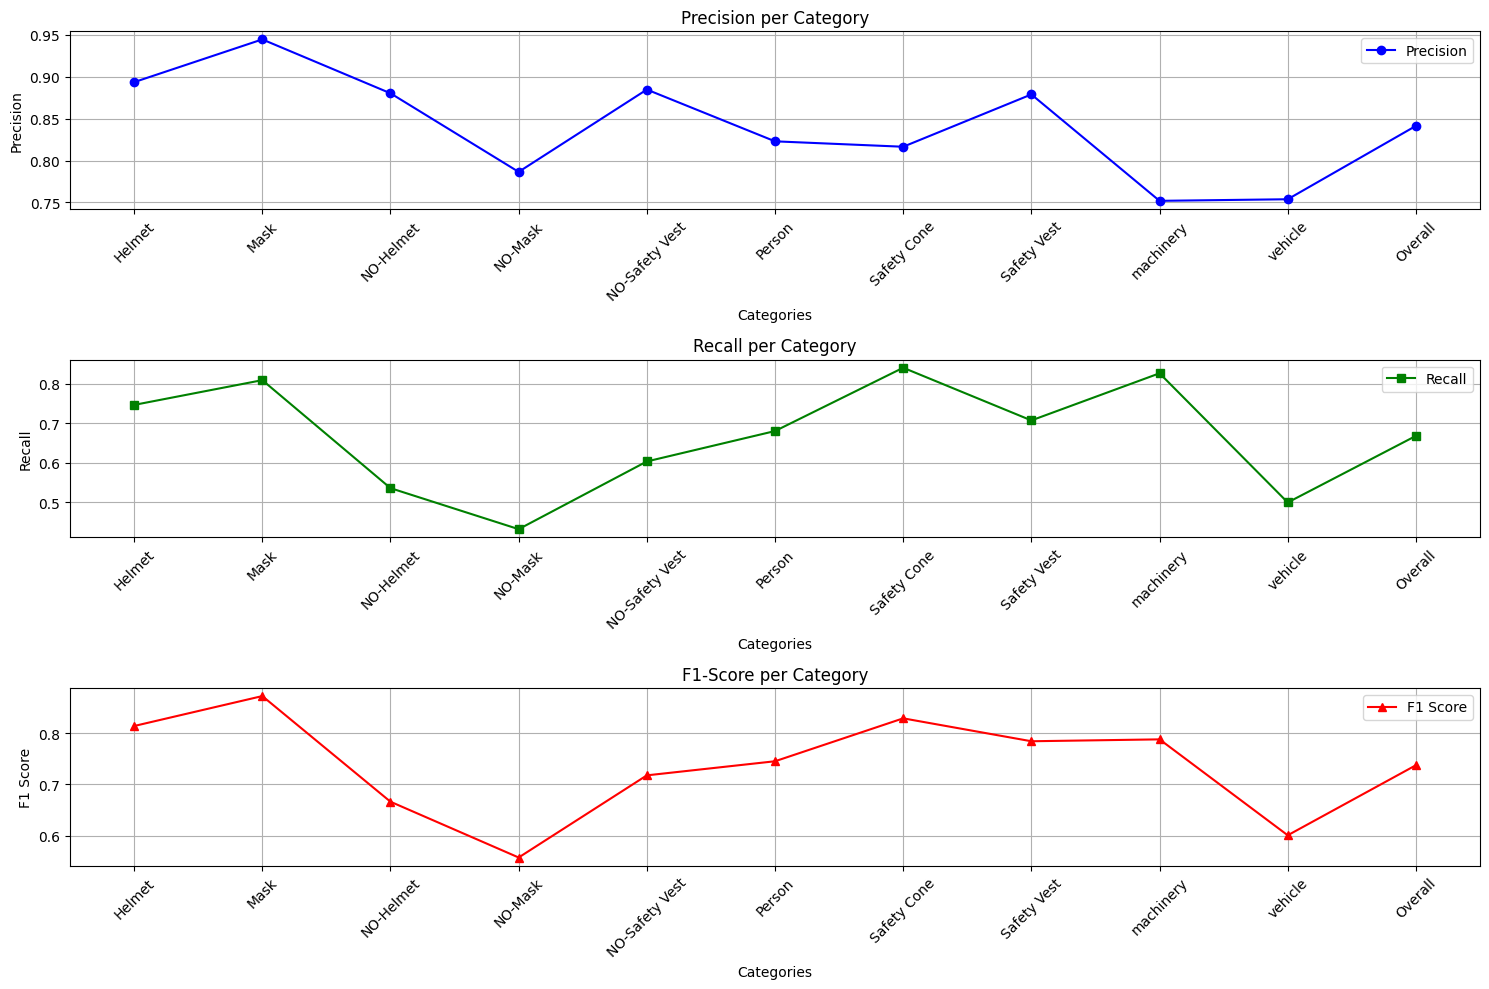

In [22]:
model = YOLO('/content/runs/detect/yolov8n_v1_train/weights/best.pt')

# Evaluate model on test dataset
metrics = model.val()  # Returns evaluation results

# Extract class names
categories = list(metrics.names.values())  # Convert dict to list
num_classes = len(categories)

# Extract metrics
precision = metrics.box.p.tolist()  # Precision per class
recall = metrics.box.r.tolist()  # Recall per class
f1_score = [2 * (p * r) / (p + r + 1e-6) for p, r in zip(precision, recall)]  # Compute F1-score

# 🔹 Add "Overall" Average
categories.append("Overall")
precision.append(np.mean(precision))
recall.append(np.mean(recall))
f1_score.append(np.mean(f1_score))

# 🔥 PLOTTING PRECISION, RECALL, F1-SCORE 🔥

plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.plot(categories, precision, marker='o', linestyle='-', color='blue', label="Precision")
plt.xlabel("Categories")
plt.ylabel("Precision")
plt.title("Precision per Category")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(categories, recall, marker='s', linestyle='-', color='green', label="Recall")
plt.xlabel("Categories")
plt.ylabel("Recall")
plt.title("Recall per Category")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(categories, f1_score, marker='^', linestyle='-', color='red', label="F1 Score")
plt.xlabel("Categories")
plt.ylabel("F1 Score")
plt.title("F1-Score per Category")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


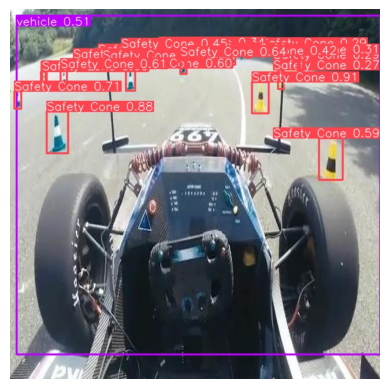

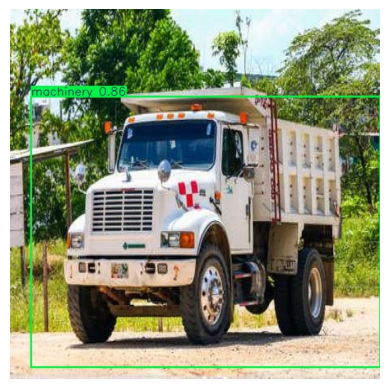

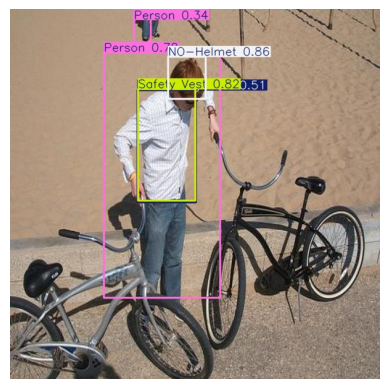

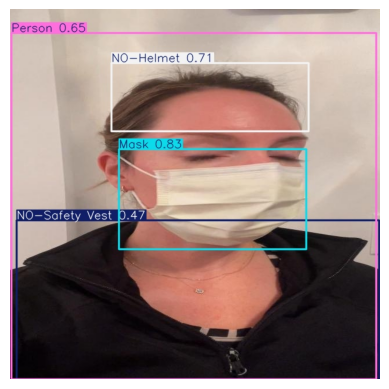

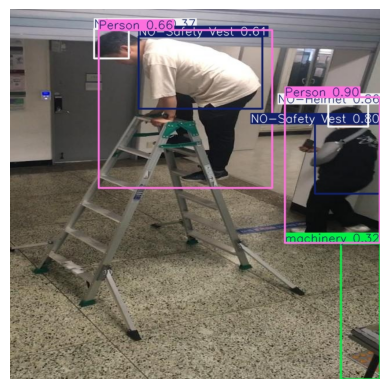

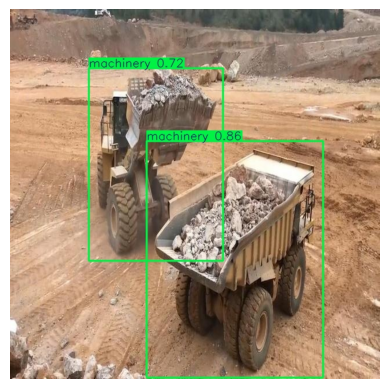

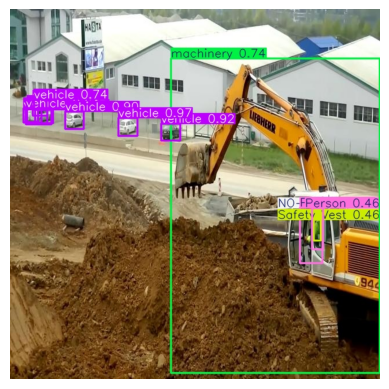

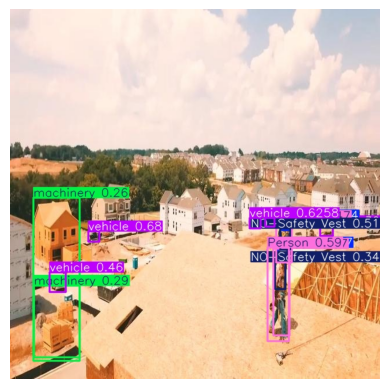

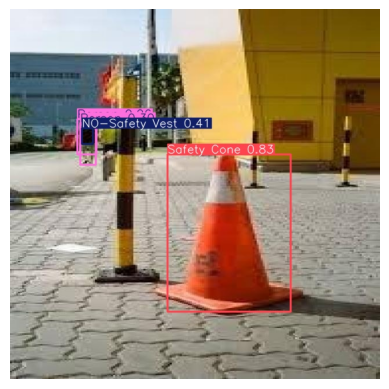

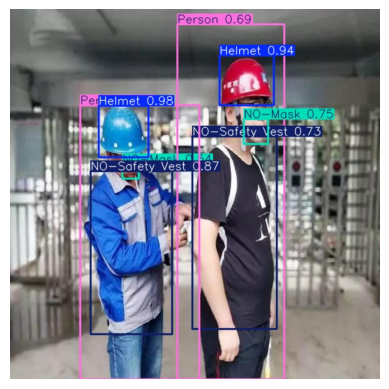

In [23]:
import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Fix glob path
predictions = glob.glob('/content/runs/detect/predict/*')

# Check if predictions list is empty
if len(predictions) == 0:
    print("⚠️ No detected images found in the specified directory.")
else:
    n = min(10, len(predictions))  # Ensure n does not exceed available images

    for i in range(n):
        idx = np.random.randint(0, len(predictions))
        image = Image.open(predictions[idx])
        plt.imshow(image)
        plt.axis("off")  # Remove grid and axes
        plt.show()
